In [1]:
import os
import pickle
#import rpy2.robjects as robjects
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import scipy.sparse as sp
from torchvision import transforms as tfs
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.nn import HGTConv, Linear
#from torch_geometric.loader import HGTLoader
from torch.cuda.amp import autocast
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torchsummary import summary
import random
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from torch.utils.data import WeightedRandomSampler
import math
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch.nn.parameter import Parameter

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2022)

class eca_layer(nn.Module):
    """Constructs a ECA module.
    Args:
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
    """
    def __init__(self, channel, k_size=3):
        super(eca_layer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        #print(x.size())
        y = self.avg_pool(x)
        #print(y.size())
        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        #print(y.size())
        # Multi-scale information fusion
        y = self.sigmoid(y)
        #print(y.size())
        out=x * y.expand_as(x)
        #print(out.size())
        return out


def default(val, d):
    return val if exists(val) else d

def exists(val):
    return val is not None

def conv_kx1(in_channels, out_channels, kernel_size, stride=1):
    layers = []
    padding = kernel_size - 1
    padding_left = padding // 2
    padding_right = padding - padding_left
    layers.append(nn.ConstantPad1d((padding_left, padding_right), 0))
    layers.append(nn.Conv1d(in_channels, out_channels, kernel_size, stride))
    return nn.Sequential(*layers)

def conv_kx2(in_channels, out_channels, kernel_size, stride=1):
    layers = []
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    return nn.Sequential(*layers)

class Conv2_Layer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(Conv2_Layer, self).__init__()
        #self.relu = nn.ReLU()
        #self.eca1=eca_layer(in_channels,3)
        self.conv1 = conv_kx2(in_channels, out_channels[0], kernel_size)
        self.norm1=nn.BatchNorm2d(out_channels[0])
        self.eca2=eca_layer(out_channels[0],3)
        self.conv2 = conv_kx2(out_channels[0], out_channels[1], kernel_size)
        self.norm2=nn.BatchNorm2d(out_channels[1])
        self.eca3=eca_layer(out_channels[1],3)
        self.relu=nn.GELU()
    def forward(self, x):
        #out = self.eca1(x)
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.eca2(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.eca3(out)
        out = self.relu(out)
        return out

def ConvBlock(dim, dim_out = None, kernel_size = 1):
    return nn.Sequential(
        nn.BatchNorm1d(dim),
        nn.GELU(),
        conv_kx1(dim, default(dim_out, dim), kernel_size))

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout = 0.3, max_len=35526):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * (-(math.log(10000.0) / d_model)))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],requires_grad=False)
        return self.dropout(x)

class gCNN(nn.Module):
    def __init__(self,max_len=2500,dim=128,nhead=4,num_layers=2,pool_size=[(3,1),3,11],out_channels=[7,1],stem_kernel_size=[(7,1),7],dropout_rate=0.3):
        super(gCNN, self).__init__()
        self.stem1 = nn.Sequential(
            Conv2_Layer(15,out_channels,stem_kernel_size[0]),
            nn.MaxPool2d(pool_size[0])
        )
        out_length = np.floor((((max_len-(stem_kernel_size[0][0]*2)+2) - pool_size[0][0]) / pool_size[0][0]) + 1)
        print(out_length)
        self.stem2 = nn.Sequential(
            conv_kx1(4, dim, stem_kernel_size[1]),
            Residual(ConvBlock(dim,dim,stem_kernel_size[1])),
            nn.MaxPool1d(pool_size[1])
        )
        out_length = np.floor(((out_length - pool_size[1]) / pool_size[1]) + 1)
        print(out_length)
        self.stem3 = nn.Sequential(
            #conv_kx1(64, dim, stem_kernel_size[1]),
            Residual(ConvBlock(dim,dim,stem_kernel_size[1])),
            nn.MaxPool1d(pool_size[2])
        )
        out_length = np.floor(((out_length - pool_size[2]) / pool_size[2]) + 1)
        print(out_length)
        self.position = PositionalEncoding(d_model=dim,max_len=int(out_length))
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead,batch_first=True,dim_feedforward=256,activation='gelu',dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.linear = nn.Linear(int(dim * out_length), 1024)
        # self.relu = nn.GELU()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def forward(self, x):
        #print(x.size())
        x = self.stem1(x)
        #print(x.size())
        x=x.view(x.size()[0],x.size()[2],x.size()[3])
        #print(x.size())
        x=x.permute(0,2,1)
        #print(x.size())
        x=self.stem2(x)
        #print(x.size())
        x=self.stem3(x)
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.position(x)
        #print(x.size())
        x = self.transformer_encoder(x)
        #print(x.size())
        x = x.reshape(len(x), -1)
        #print(x.size())
        # x = self.linear(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        #print(x.size())
        return x

class mCNN(nn.Module):
    def __init__(self,max_len=25,dim=128,nhead=8,num_layers=2,stem_kernel_size=7,dropout_rate=0.3):
        super(mCNN, self).__init__()
        self.stem = nn.Sequential(
            #nn.Conv1d(4, dim, 7),
            conv_kx1(4, dim, stem_kernel_size),
            Residual(ConvBlock(dim,dim,stem_kernel_size))
            #AttentionPool(dim, pool_size = 2)
        )
        self.position = PositionalEncoding(d_model=dim,max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead,batch_first=True,dim_feedforward=256,activation='gelu',dropout=dropout_rate)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        # self.linear = nn.Linear(int(dim * max_len), 1024)
        # self.relu = nn.GELU()
        # self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def forward(self, x):
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.stem(x)
        #print(x.size())
        #x = self.conv_tower(x)
        #print(x.size())
        x=x.permute(0, 2, 1)
        #print(x.size())
        x = self.position(x)
        #print(x.size())
        x = self.transformer_encoder(x)
        #print(x.size())
        x = x.reshape(len(x), -1)
        #print(x.size())
        # x = self.linear(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        #print(x.size())
        return x

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers,node_types,metadata):
        super().__init__()
        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels[0])
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            conv = HGTConv(hidden_channels[i], hidden_channels[i+1], metadata,num_heads, group='sum')
            self.convs.append(conv)
    def forward(self, x_dict, edge_index_dict):
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.lin_dict[node_type](x).relu_()
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        # xm=self.relu(self.lin1(x_dict['miRNA']))
        # xg=self.relu(self.lin2(x_dict['gene']))
        xm=x_dict['miRNA']
        xg=x_dict['gene']
        return (xm,xg)


class MLPBilPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
        super(MLPBilPredictor, self).__init__()
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
        for i in range(num_layers - 1):
            self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
        self.bilin = torch.nn.Linear(hidden_channels[-1], hidden_channels[-1], bias=False)
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
        self.relu = nn.GELU()

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        self.bilin.reset_parameters()

    def forward(self, x_i, x_j):
        for lin in self.lins:
            x_i, x_j = lin(x_i), lin(x_j)
            x_i, x_j = self.dropout(self.relu(x_i)), self.dropout(self.relu(x_j))
        x = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
        # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
        # x = x1+x2
        # x = torch.sum(x_i * x_j, dim=-1)
        return x,x_i,x_j

# class MLPBilPredictor(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, num_layers, dropout_rate=0.3):
#         super(MLPBilPredictor, self).__init__()
#         self.lins = torch.nn.ModuleList()
#         self.lins.append(torch.nn.Linear(in_channels, hidden_channels[0]))
#         for i in range(num_layers - 1):
#             self.lins.append(torch.nn.Linear(hidden_channels[i], hidden_channels[i+1]))
#         # self.bilin = torch.nn.Linear(hidden_channels, hidden_channels, bias=False)
#         # self.bilin = torch.nn.Linear(in_channels,in_channels, bias=False)
#         self.pre = torch.nn.Linear(hidden_channels[-1],1)
#         self.relu = nn.GELU()
#         self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
#
#     def reset_parameters(self):
#         for lin in self.lins:
#             lin.reset_parameters()
#         self.lin.reset_parameters()
#
#     def forward(self, x):
#         for lin in self.lins:
#             x= lin(x)
#             x= self.dropout(self.relu(x))
#         x = self.pre(x)
#         # x1 = torch.sum(self.bilin(x_i) * x_j, dim=-1)
#         # x2 = torch.sum(self.bilin(x_j) * x_i, dim=-1)
#         # x = x1+x2
#         # x = torch.sum(x_i * x_j, dim=-1)
#         return x

class HerGraph(torch.nn.Module):
    def __init__(self,hidden_channels, hgtout_channels, num_heads, hgtnum_layers,node_types,metadata, \
                 max_len=[25,2500],dim=[128,128],nhead=[4,4],num_layers=[2,2],pool_size=[(3,1),3], \
                 out_channels=[7,1],stem_kernel_size=[(7,1),7],herout_channels=128,dropout_rate=0.3):
        super(HerGraph, self).__init__()
        self.mcnn = mCNN(max_len[0],dim[0],nhead[0],num_layers[0],stem_kernel_size[1],dropout_rate)
        self.gcnn = gCNN(max_len[1],dim[1],nhead[1],num_layers[1],pool_size,out_channels,stem_kernel_size,dropout_rate)
        self.hgt=HGT(hidden_channels, hgtout_channels, num_heads, hgtnum_layers,node_types,metadata)
        self.pre=MLPBilPredictor(3200+128, [1024], 1, 0.3)
        self.relu = nn.GELU()
        #self.ZeroPad = nn.ZeroPad2d(padding=(0, 1024-128, 0, 0))
        self.dropout = nn.Dropout(p=dropout_rate if dropout_rate is not None else 0)
    def encoder(self,seq_dict,x_dict,edge_index_dict):
        xm1=self.mcnn(seq_dict['miRNA'])
        #print(xm1.size())
        xg1=self.gcnn(seq_dict['gene'])
        #print(xg1.size())
        xm2,xg2=self.hgt(x_dict,edge_index_dict)
        # torch.nn.ZeroPad2d(padding=(0, 2, 0, 2))
        # xm2 = self.ZeroPad(xm2)
        # xg2 = self.ZeroPad(xg2)
        #xm2=self.relu(self.embhgt(xm2))
        #xg2=self.relu(self.embhgt(xg2))
        xm=self.relu(torch.cat([xm1, xm2], dim=1))
        #print(xm.size())
        xg=self.relu(torch.cat([xg1, xg2], dim=1))
        #print(xg.size())
        # xm=xm1+xm2
        # xg=xg1+xg2
        #xm = self.dropout(xm)
        #xg = self.dropout(xg)
        #print(xm.size())
        #print(xg.size())
        return xm,xg
    def decoderMLP(self,xm,xg,edge):
        xm=xm[edge[0]]
        xg=xg[edge[1]]
        #x=torch.cat([xm, xg], dim=1)
        #s=self.pre(x)
        s,xm,xg=self.pre(xm,xg)
        return s,xm,xg
    def forward(self,seq_dict,x_dict,edge_index_dict,label_edge):
        xm,xg=self.encoder(seq_dict,x_dict,edge_index_dict)
        s,xm,xg=self.decoderMLP(xm,xg,label_edge)
        return s,xm,xg
    
class FocalLoss(nn.Module):
    def __init__(self,alpha=0.25,gamma=2.0,reduce='mean'):
        super(FocalLoss,self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self,classifications,targets):
        # classifcation:[N,K]
        # targets: [N,K]的one-hot编码
        alpha = self.alpha
        gamma = self.gamma
        # classifications = classifications.view(-1)  # 不经过sigmoid的classification；
        # targets = targets.view(-1)                  # 应该是 one-hot
        # ce_loss: 对应公式中 -log(pt),也就是普通的 交叉熵损失；--> 该函数接收未经sigmoid的函数；
        ce_loss = F.binary_cross_entropy_with_logits(classifications, targets, reduction="none")
        #focal loss
        p = torch.sigmoid(classifications)                # 经过sigmoid
        p_t = p * targets + (1 - p) * (1 - targets)       #  计算pt
        loss = ce_loss * ((1 - p_t) ** gamma)             # -log(pt) * (1-pt) ** ganmma
        if alpha >= 0:
            # 对应公式中alpha_t控制损失的权重
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets) # 和pt求解过程一样
            loss = alpha_t * loss                         # 最终focal loss
        if self.reduce=='sum':
            loss = loss.sum()
        elif self.reduce=='mean':
            loss = loss.mean()
        else:
            raise ValueError('reduce type is wrong!')
        return loss

class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, _input, target):
        pt = torch.sigmoid(_input)
        loss = - self.alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1-self.alpha)*pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        #         loss = - self.alpha * pt ** self.gamma * target * torch.log(pt) - \
        #             (1-self.alpha)*(1 - pt)** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss

def trainAll(model,train_data,lossF):
    model.train()
    out,_,_  = model(train_data.seq_dict,train_data.sim_dict,train_data.edge_index_dict,train_data['regulate'].edge_label_index)
    out=out.view(-1)
    #print('out')
    rel=train_data['regulate'].edge_label
    #loss = F.binary_cross_entropy_with_logits(out,rel)
    loss=lossF(out,rel)
    pre=torch.sigmoid(out)
    assert torch.isnan(loss).sum() == 0, print(loss)
    auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    #     out = model(train_data.x_dict,train_data.edge_index_dict)
    #     pre=out[train_data['regulate'].edge_label_index[0],train_data['regulate'].edge_label_index[1]]
    #     rel=train_data['regulate'].edge_label
    #     loss = F.binary_cross_entropy_with_logits(pre,rel)
    #     pre=torch.sigmoid(pre)
    #     assert torch.isnan(loss).sum() == 0, print(loss)
    #     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return (loss.item(),auc,aupr)

def evaluateAll(model,dat,lossF):
    model.eval()
    valloss=0
    valauc=0
    with torch.no_grad():
        out,_,_  = model(dat.seq_dict,dat.sim_dict,dat.edge_index_dict,dat['regulate'].edge_label_index)
        out=out.view(-1)
        rel=dat['regulate'].edge_label
        #loss = F.binary_cross_entropy_with_logits(out,rel)
        loss=lossF(out,rel)
        pre=torch.sigmoid(out)
        #         out = model(dat.x_dict,dat.edge_index_dict)
        #         pre=out[dat['regulate'].edge_label_index[0],dat['regulate'].edge_label_index[1]]
        #         rel=dat['regulate'].edge_label
        #         loss = F.binary_cross_entropy_with_logits(pre,rel)
        #         pre=torch.sigmoid(pre)
        auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
        aupr= average_precision_score(rel.detach().numpy(), pre.detach().numpy())
    return (loss.item(),auc,aupr)

class EarlyStopping():
    def __init__(self, tolerance=50, min_delta=0.1):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
    def __call__(self, val_best_auc, val_auc):
        if val_auc<val_best_auc:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

def transfer_model(pretrained_file, model):
    pretrained_dict = torch.load(pretrained_file,map_location=torch.device('cpu'))  # get pretrained dict
    model_dict = model.state_dict()  # get model dict
    pretrained_dict = transfer_state_dict(pretrained_dict, model_dict)
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

def transfer_state_dict(pretrained_dict, model_dict):
    state_dict = {}
    for k, v in pretrained_dict.items():
        if k in model_dict.keys():
            state_dict[k] = v
        else:
            print("Missing key(s) in state_dict :{}".format(k))
    return state_dict


# if __name__ == '__main__':
#     with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_newall.pkl','rb') as f:  # Python 3: open(..., 'rb')
#         train_data,val_data,test_data,m,g = pickle.load(f)

#     train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
#     train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
#     nodetypes=train_data.node_types
#     metadata=train_data.metadata()
    
#     model = HerGraph(hidden_channels=[1024,256,128], hgtout_channels=128, num_heads=8, hgtnum_layers=2,node_types=nodetypes,metadata=metadata, \
#                  max_len=[25,2500],dim=[128,128],nhead=[8,8],num_layers=[1,1],pool_size=[(3,1),3,11], \
#                  out_channels=[7,1],stem_kernel_size=[(7,1),3],herout_channels=128,dropout_rate=0.3)
    

#     print(model)

#     pretrained_file='/lustre06/project/6050659/liupei89/Testcell/TransCNN13_1.pth'
#     model = transfer_model(pretrained_file, model)

#     pretrained_file='/lustre06/project/6050659/liupei89/Testcell/HGT6_1.pth'
#     model = transfer_model(pretrained_file, model)

#     for i, param in enumerate(model.parameters()):
#         if i < 50:      # 前面一些参数冻结 需要再看
#             param.requires_grad = False
#     #     hgt=list(map(id, model.hgt.parameters()))
#     #     mcnn=list(map(id, model.mcnn.parameters()))
#     #     gcnn=list(map(id, model.gcnn.parameters()))
#     #     base_params = filter(lambda p: id(p) not in hgt,mcnn,gcnn model.parameters())
#     # ti=[18,19]
#     # for i, param in enumerate(model.parameters()):
#     #     if i in ti:      # 解冻
#     #         param.requires_grad = True
#     #     optimizer = torch.optim.Adam([{'params': base_params},{'params': model.hgt.parameters(), 'lr': 0.0001}], lr=0.000001,weight_decay=0)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-3)
#     lossF=FocalLoss(alpha=0.65, gamma=2,reduce='mean')
#     #lossF=BCEFocalLoss(gamma=1, alpha=0.75, reduction='elementwise_mean')
#     early_stopping = EarlyStopping(tolerance=200, min_delta=0.15)

#     import time
#     best_val_auc= best_val_aupr= 0
#     trainloss=[]
#     valloss=[]
#     valauc=[]
#     trainauc=[]
#     valaupr=[]
#     trainaupr=[]
#     lrchange=[]
#     for epoch in range(1, 501):
#         since = time.time()
#         print('{} optim: {}'.format(epoch, optimizer.param_groups[0]['lr']))
#         lrchange.append(optimizer.param_groups[0]['lr'])
#         train_loss,train_auc,train_aupr = trainAll(model,train_data,lossF)
#         trainloss.append(train_loss)
#         print('train_loss:',train_loss)
#         #time_elapsed = time.time() - since
#         #print('Training in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         #since1 = time.time()
#         val_loss,val_auc,val_aupr = evaluateAll(model,val_data,lossF)
#         valauc.append(val_auc)
#         valloss.append(val_loss)
#         trainauc.append(train_auc)
#         valaupr.append(val_aupr)
#         trainaupr.append(train_aupr)
#         #time_elapsed = time.time() - since1
#         #print('Val and Testing in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#         if val_aupr > best_val_aupr:
#             best_val_auc = val_auc
#             best_val_aupr=val_aupr
#             torch.save(model, 'Modelbest.pt')
#         #    test_auc= tmp_test_auc
#         #scheduler.step()
#         time_elapsed = time.time() - since
#         log = 'Epoch: {:03d}, Epoch complete in {:.0f}m {:.0f}s, trainLoss: {:.4f}, Valloss: {:.4f}, Trainauc: {:.4f}, Valauc: {:.4f}, Valbestauc: {:.4f},Trainaupr: {:.4f}, Valaupr: {:.4f}, Valbestaupr: {:.4f}'
#         print(log.format(epoch, time_elapsed // 60, time_elapsed % 60,train_loss, val_loss,train_auc,val_auc,best_val_auc,train_aupr,val_aupr,best_val_aupr))

#         # early_stopping(train_auc, val_auc)
#         # if early_stopping.early_stop:
#         #     print("We are at epoch:", epoch)
#         #     break

#     with open('ModelResult.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#         pickle.dump([trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange], f)

#     torch.save(model, 'Model.pt')

In [2]:
import matplotlib.pyplot as plt

In [3]:
###重头开始
#/home/liupei89/shfolder/new/Her/4/0.001_bilinear_500
#/home/liupei89/shfolder/new/Her/4/0.001_mlpbilinear_500
#/home/liupei89/shfolder/new/Her/4/0.0001_bilinear_500
#/home/liupei89/shfolder/new/Her/4/100/0.001_bilinear_100
#/home/liupei89/shfolder/new/Her/4/100/0.001_mlpbilinear_100
#/home/liupei89/shfolder/new/Her/4/100/0.0001_bilinear_100
#Her = torch.load("/home/liupei89/shfolder/new/Her/Modelbest.pt")
Her = torch.load("/home/liupei89/shfolder/new/Her/newHer/1/Modelbest.pt")

In [4]:
Her

HerGraph(
  (mcnn): mCNN(
    (stem): Sequential(
      (0): Sequential(
        (0): ConstantPad1d(padding=(1, 1), value=0)
        (1): Conv1d(4, 128, kernel_size=(3,), stride=(1,))
      )
      (1): Residual(
        (fn): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): GELU()
          (2): Sequential(
            (0): ConstantPad1d(padding=(1, 1), value=0)
            (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
          )
        )
      )
    )
    (position): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropo

In [5]:
with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newdataCombine00_newall.pkl','rb') as f:  # Python 3: open(..., 'rb')
        train_data,val_data,test_data,m,g = pickle.load(f)

train_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
val_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
test_data ['miRNA'].sim = train_data ['miRNA'].mm + train_data ['miRNA'].x
train_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
val_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
test_data ['gene'].sim = train_data ['gene'].gg + train_data ['gene'].x
nodetypes=train_data.node_types
metadata=train_data.metadata()

In [6]:
train_data

HeteroData(
  miRNA={
    x=[279, 279],
    seq=[279, 25, 4],
    mm=[279, 279],
    sim=[279, 279]
  },
  gene={
    x=[14676, 14676],
    seq=[14676, 15, 2500, 4],
    gg=[14676, 14676],
    sim=[14676, 14676]
  },
  (miRNA, regulate, gene)={
    edge_index=[2, 66514],
    edge_label_index=[2, 66514],
    edge_label=[66514]
  },
  (gene, coocurrence, gene)={ edge_index=[2, 2087674] },
  (miRNA, cofamily, miRNA)={ edge_index=[2, 418] },
  (gene, rev_regulate, miRNA)={ edge_index=[2, 66514] }
)

In [7]:
val_data

HeteroData(
  miRNA={
    x=[279, 279],
    seq=[279, 25, 4],
    mm=[279, 279],
    sim=[279, 279]
  },
  gene={
    x=[14676, 14676],
    seq=[14676, 15, 2500, 4],
    gg=[14676, 14676],
    sim=[14676, 14676]
  },
  (miRNA, regulate, gene)={
    edge_index=[2, 66514],
    edge_label_index=[2, 7391],
    edge_label=[7391]
  },
  (gene, coocurrence, gene)={ edge_index=[2, 2087674] },
  (miRNA, cofamily, miRNA)={ edge_index=[2, 418] },
  (gene, rev_regulate, miRNA)={ edge_index=[2, 66514] }
)

In [8]:
test_data

HeteroData(
  miRNA={
    x=[279, 279],
    seq=[279, 25, 4],
    mm=[279, 279],
    sim=[279, 279]
  },
  gene={
    x=[14676, 14676],
    seq=[14676, 15, 2500, 4],
    gg=[14676, 14676],
    sim=[14676, 14676]
  },
  (miRNA, regulate, gene)={
    edge_index=[2, 73905],
    edge_label_index=[2, 8213],
    edge_label=[8213]
  },
  (gene, coocurrence, gene)={ edge_index=[2, 2087674] },
  (miRNA, cofamily, miRNA)={ edge_index=[2, 418] },
  (gene, rev_regulate, miRNA)={ edge_index=[2, 73905] }
)

In [5]:
torch.cat([train_data['regulate'].edge_index,val_data['regulate'].edge_label_index,test_data['regulate'].edge_label_index],dim=1).size()

torch.Size([2, 82118])

In [4]:
torch.cat([train_data['regulate'].edge_label,val_data['regulate'].edge_label,test_data['regulate'].edge_label]).size()

torch.Size([82118])

In [12]:
with open('/lustre06/project/6050659/liupei89/Testcell/newNetData/pos_neg/newmirtarpos.pkl','rb') as f:  # Python 3: open(..., 'rb')
        newtestedge = pickle.load(f)

In [16]:
newtestedge[0][0:2,0:3000].size()

torch.Size([2, 3000])

In [9]:
### test 余下的边 在miRTarBAse

Her.eval()
valloss=0
valauc=0
with torch.no_grad():
#     out = Her(test_data.seq_dict,test_data.x_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
#     pre=out[test_data['regulate'].edge_label_index[0],test_data['regulate'].edge_label_index[1]]
#     rel=test_data['regulate'].edge_label
#     loss = F.binary_cross_entropy_with_logits(pre,rel)
#     pre=torch.sigmoid(pre)

    out, _, _ = Her(test_data.seq_dict,test_data.sim_dict,test_data.edge_index_dict,newtestedge[0][0:2,0:3000])
    out=out.view(-1)
    #rel=test_data['regulate'].edge_label
    #loss = F.binary_cross_entropy_with_logits(out,rel)
    pre=torch.sigmoid(out) 

    #auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())

NameError: name 'newtestedge' is not defined

In [24]:
out1=out
pre1=pre

In [25]:
# Her.eval()
# valloss=0
# valauc=0
# with torch.no_grad():
# #     out = Her(test_data.seq_dict,test_data.x_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
# #     pre=out[test_data['regulate'].edge_label_index[0],test_data['regulate'].edge_label_index[1]]
# #     rel=test_data['regulate'].edge_label
# #     loss = F.binary_cross_entropy_with_logits(pre,rel)
# #     pre=torch.sigmoid(pre)

#     out = Her(test_data.seq_dict,test_data.sim_dict,test_data.edge_index_dict,newtestedge[0])
#     out=out.view(-1)
#     #rel=test_data['regulate'].edge_label
#     #loss = F.binary_cross_entropy_with_logits(out,rel)
#     pre=torch.sigmoid(out) 


In [26]:
pre

tensor([0.2106, 0.6379, 0.4640,  ..., 0.3954, 0.3909, 0.2070])

In [27]:
out

tensor([-1.3215,  0.5663, -0.1444,  ..., -0.4245, -0.4436, -1.3428])

In [28]:
pre1

tensor([0.2106, 0.6379, 0.4640,  ..., 0.9347, 0.8337, 0.6267])

In [29]:
out1

tensor([-1.3215,  0.5663, -0.1444,  ...,  2.6614,  1.6120,  0.5181])

In [ ]:
get_rmse(records_real, records_predict)

In [11]:
# Her.eval()
# valloss=0
# valauc=0
# with torch.no_grad():
# #     out = Her(test_data.seq_dict,test_data.x_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
# #     pre=out[test_data['regulate'].edge_label_index[0],test_data['regulate'].edge_label_index[1]]
# #     rel=test_data['regulate'].edge_label
# #     loss = F.binary_cross_entropy_with_logits(pre,rel)
# #     pre=torch.sigmoid(pre)

#     out = Her(test_data.seq_dict,test_data.sim_dict,test_data.edge_index_dict,test_data['regulate'].edge_label_index)
#     out=out.view(-1)
#     rel=test_data['regulate'].edge_label
#     #loss = F.binary_cross_entropy_with_logits(out,rel)
#     pre=torch.sigmoid(out) 

#     auc=roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    
Her.eval()
valloss = 0
valauc = 0
with torch.no_grad():
    out, _, _ = Her(test_data.seq_dict, test_data.sim_dict, test_data.edge_index_dict, test_data['regulate'].edge_label_index)
    out = out.view(-1)
    rel = test_data['regulate'].edge_label
    # loss = F.binary_cross_entropy_with_logits(out,rel)
    #loss = lossF(out, rel)
    pre = torch.sigmoid(out)
    auc = roc_auc_score(rel.detach().numpy(), pre.detach().numpy())
    aupr = average_precision_score(rel.detach().numpy(), pre.detach().numpy())

In [12]:
print(auc,aupr)

0.8625718227334958 0.7954255135159227


In [13]:
#rel[rel==1].size()
allrelpos=torch.nonzero(rel==1).squeeze()
print(allrelpos.size())
allrelneg=torch.nonzero(rel==0).squeeze()
print(allrelneg.size())

allprepos=torch.nonzero(pre>=0.5).squeeze()##从0开始
print(allprepos.size())
allpreneg=torch.nonzero(pre<0.5).squeeze()##从0开始
print(allpreneg.size())

torch.Size([2223])
torch.Size([5990])
torch.Size([2207])
torch.Size([6006])


In [14]:
a=set(allprepos.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
tp=c
print(tp.size())#1571

a=set(allprepos.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
fp=c
print(fp.size())#797

a=set(allpreneg.numpy())
b=set(allrelneg.numpy())
c=torch.tensor(list(a&b))
tn=c
print(tn.size())#5193

a=set(allpreneg.numpy())
b=set(allrelpos.numpy())
c=torch.tensor(list(a&b))
fn=c
print(fn.size())#652

torch.Size([1576])
torch.Size([631])
torch.Size([5359])
torch.Size([647])


In [15]:
tp.size(0)+fn.size(0)

2223

In [16]:
recall=tp.size(0)/(tp.size(0)+fn.size(0))
print(recall)

precision=tp.size(0)/(tp.size(0)+fp.size(0))
print(precision)

f1 = 2 * precision * recall / (precision + recall)
print(f1)

0.7089518668466037
0.7140915269596738
0.7115124153498871


In [17]:
with open('HerGraph1_result.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([tp,fp,tn,fn,rel,pre], f)

In [2]:
with open('newHer4test_result.pkl','rb') as f:  # Python 3: open(..., 'rb')
        tp,fp,tn,fn,rel,pre = pickle.load(f)

In [16]:
# v,index=torch.topk(pre1, 200, largest=True, sorted=True, out=None) 

In [36]:
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [37]:
fpr, tpr, thresholds = roc_curve(rel.numpy(), pre.numpy(), pos_label=1)
testauc=auc(fpr,tpr)
print(testauc)

[0.         0.         0.         ... 0.98180301 0.98180301 1.        ] [0.00000000e+00 4.49842555e-04 7.10751237e-02 ... 9.99550157e-01
 1.00000000e+00 1.00000000e+00] 0.8717220258385358


In [18]:
tnr=tn.size(0)/(tn.size(0)+fp.size(0))
tnr #真阴

0.8946577629382304

In [19]:
fpr=fp.size(0)/(tn.size(0)+fp.size(0))
fpr #假阳

0.10534223706176962

In [20]:
acc=(tp.size(0)+tn.size(0))/(tn.size(0)+fp.size(0)+fn.size(0)+tp.size(0))
acc #准确率

0.8443930354316328

In [21]:
#precision, recall, _ = precision_recall_curve(rel.numpy(), pre.numpy(),pos_label=1)
testaupr= average_precision_score(rel.numpy(), pre.numpy())
testaupr #0.8026

0.7954255135159227

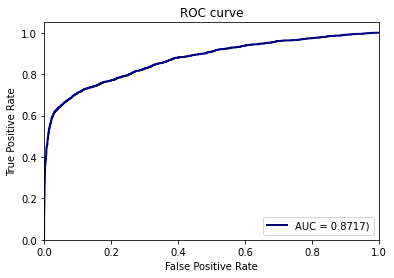

In [21]:
plt.figure()
plt.step(fpr, tpr,color='navy',linewidth=2,label='AUC = {0:.4f})'.format(testauc))
#plt.plot([0, 0], [1, 1], color='navy',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
#plt.savefig("auc_curve.jpg")

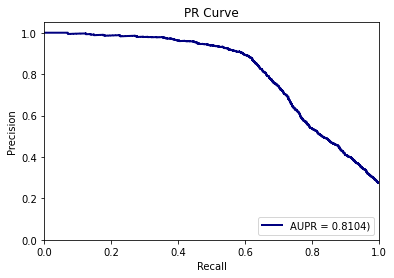

In [22]:
plt.figure()
plt.step(recall,precision,color='navy',linewidth=2,label='AUPR = {0:.4f})'.format(testaupr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('PR Curve')
plt.legend(loc=4)
#plt.savefig("pr_curve.jpg")

In [23]:
t1=rel.numpy()
print(len(t1))
print(len(t1[t1==1]))
s1=pre.numpy()
s1[s1>0.5]=1
s1[s1<=0.5]=0
print(len(s1[s1==1]))

8213
2223
2099


In [24]:
precision = precision_score(t1, s1,pos_label=1)
print(precision)
recall = recall_score(t1, s1,pos_label=1)
print(recall)
f1 = f1_score(t1, s1,pos_label=1)
print(f1)

0.7417818008575512
0.7004048582995951
0.7204997686256362


In [ ]:
#/home/liupei89/shfolder/new/Her/3/0.001/0.001_bilinear_500
#/home/liupei89/shfolder/new/Her/4/0.001_bilinear_500
#/home/liupei89/shfolder/new/Her/4/100/0.001_bilinear_100
#/home/liupei89/shfolder/new/Her/4/100/0.0001_bilinear_100

In [ ]:
#/home/liupei89/shfolder/new/Her/4/0.0001_bilinear_500
#/home/liupei89/shfolder/new/Her/3/0.0001_bilinear_500

In [22]:
with open('/home/liupei89/shfolder/new/Her/newHer/1/ModelResult.pkl','rb') as f:  # Python 3: open(..., 'rb')
        trainloss, trainauc,trainaupr,valloss,valauc,valaupr,lrchange = pickle.load(f)

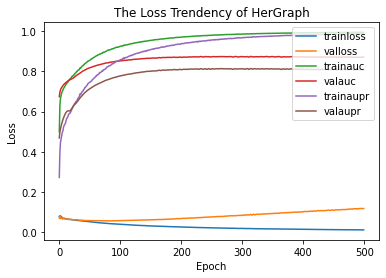

In [23]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss')
plt.plot(valloss,label='valloss')
plt.plot(trainauc,label='trainauc')
plt.plot(valauc,label='valauc')
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('The Loss Trendency of HerGraph')
plt.legend(loc=1)

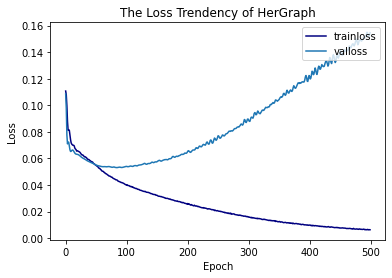

In [27]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainloss,label='trainloss',color='navy')
plt.plot(valloss,label='valloss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.0, 1.0])
#plt.xlim([0.0, 1.0])
plt.title('The Loss Trendency of HerGraph')
plt.legend(loc=1)

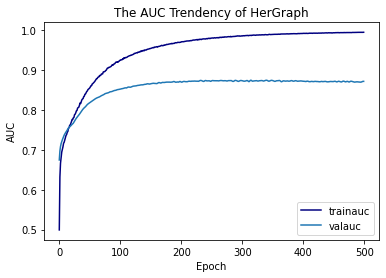

In [24]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainauc,label='trainauc',color='navy')
plt.plot(valauc,label='valauc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('The AUC Trendency of HerGraph')
plt.legend(loc=4)

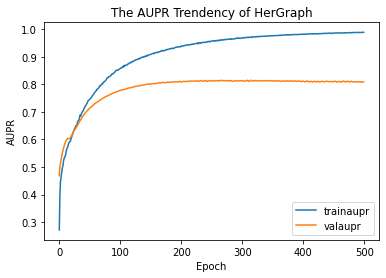

In [25]:
#plt.plot(trainloss)
plt.figure()
plt.plot(trainaupr,label='trainaupr')
plt.plot(valaupr,label='valaupr')
plt.xlabel('Epoch')
plt.ylabel('AUPR')
#plt.ylim([0.5, 0.71])
plt.title('The AUPR Trendency of HerGraph')
plt.legend(loc=4)

In [31]:
# for name,parameters in Her.named_parameters():
#     print(name,':',parameters.size())

mcnn.stem.0.1.weight : torch.Size([128, 4, 7])
mcnn.stem.0.1.bias : torch.Size([128])
mcnn.stem.1.fn.0.weight : torch.Size([128])
mcnn.stem.1.fn.0.bias : torch.Size([128])
mcnn.stem.1.fn.2.1.weight : torch.Size([128, 128, 7])
mcnn.stem.1.fn.2.1.bias : torch.Size([128])
mcnn.transformer_encoder.layers.0.self_attn.in_proj_weight : torch.Size([384, 128])
mcnn.transformer_encoder.layers.0.self_attn.in_proj_bias : torch.Size([384])
mcnn.transformer_encoder.layers.0.self_attn.out_proj.weight : torch.Size([128, 128])
mcnn.transformer_encoder.layers.0.self_attn.out_proj.bias : torch.Size([128])
mcnn.transformer_encoder.layers.0.linear1.weight : torch.Size([256, 128])
mcnn.transformer_encoder.layers.0.linear1.bias : torch.Size([256])
mcnn.transformer_encoder.layers.0.linear2.weight : torch.Size([128, 256])
mcnn.transformer_encoder.layers.0.linear2.bias : torch.Size([128])
mcnn.transformer_encoder.layers.0.norm1.weight : torch.Size([128])
mcnn.transformer_encoder.layers.0.norm1.bias : torch.Size

In [32]:
num=0
for name,parameters in Her.named_parameters():
    print(num,'_',name,':',parameters.size())
    num=num+1

0 _ mcnn.stem.0.1.weight : torch.Size([128, 4, 7])
1 _ mcnn.stem.0.1.bias : torch.Size([128])
2 _ mcnn.stem.1.fn.0.weight : torch.Size([128])
3 _ mcnn.stem.1.fn.0.bias : torch.Size([128])
4 _ mcnn.stem.1.fn.2.1.weight : torch.Size([128, 128, 7])
5 _ mcnn.stem.1.fn.2.1.bias : torch.Size([128])
6 _ mcnn.transformer_encoder.layers.0.self_attn.in_proj_weight : torch.Size([384, 128])
7 _ mcnn.transformer_encoder.layers.0.self_attn.in_proj_bias : torch.Size([384])
8 _ mcnn.transformer_encoder.layers.0.self_attn.out_proj.weight : torch.Size([128, 128])
9 _ mcnn.transformer_encoder.layers.0.self_attn.out_proj.bias : torch.Size([128])
10 _ mcnn.transformer_encoder.layers.0.linear1.weight : torch.Size([256, 128])
11 _ mcnn.transformer_encoder.layers.0.linear1.bias : torch.Size([256])
12 _ mcnn.transformer_encoder.layers.0.linear2.weight : torch.Size([128, 256])
13 _ mcnn.transformer_encoder.layers.0.linear2.bias : torch.Size([128])
14 _ mcnn.transformer_encoder.layers.0.norm1.weight : torch.Size

In [25]:
for i, param in enumerate(Her.parameters()):
    print(i,param)

0 Parameter containing:
tensor([[[-0.1287,  0.2812, -0.1097,  ..., -0.0069,  0.2759,  0.2657],
         [-0.2793,  0.6601, -0.4633,  ..., -0.0046,  0.0040, -0.4729],
         [-0.1652, -0.0386, -0.0010,  ..., -0.0344,  0.2210, -0.5856],
         [ 0.5599, -0.0634,  0.1742,  ...,  0.0802, -0.2550,  0.0213]],

        [[-0.0295,  0.1051,  0.0673,  ...,  0.0793,  0.4623,  0.2683],
         [-0.0424,  0.1442,  0.1101,  ...,  0.0447, -0.0574, -0.1992],
         [ 0.0117, -0.2965, -0.1235,  ..., -0.2618, -0.0493,  0.1370],
         [ 0.0572, -0.1142, -0.2825,  ...,  0.2913,  0.0688, -0.0919]],

        [[ 0.1809, -0.1209, -0.0728,  ..., -0.1570,  0.5075,  0.0302],
         [ 0.3395, -0.4444, -0.3194,  ..., -0.0775, -0.0867,  0.4658],
         [ 0.1126, -0.1989,  0.0093,  ...,  0.2478,  0.1981, -0.0016],
         [-0.0762,  0.0447, -0.2561,  ..., -0.2805,  0.1371, -0.1608]],

        ...,

        [[ 0.1975, -0.0311,  0.4644,  ..., -0.1266, -0.0069,  0.2843],
         [-0.1441, -0.2957,  0.13

In [26]:
torch.save(Her.state_dict(),'HerGraph1.pth')